# Linear probing of DINOv2 for semantic segmentation

In this notebook, we're going to train a linear classifier on top of a frozen [DINOv2](https://huggingface.co/docs/transformers/main/model_doc/dinov2) backbone for semantic segmentation (the task of predicting a semantic category for every pixel in an image). DINOv2 is a vision transformer trained in a self-supervised fashion on a highly curated dataset of 142 million images. At the time of writing, it provides one of the best **image features** (i.e. embeddings) which one can use for downstream tasks such as image classification, image segmentation and depth estimation. This makes DINOv2 one of the best **backbones** (i.e. the first building block you typically use in your pipeline) for computer vision tasks nowadays.

In their paper, the authors show that a decoder head as simple as a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) on top of it already beats existing state-of-the-art methods. Of course, using heavier, more complex decoder heads leads to even better performance. For instance, if you add a [Mask2Former](https://huggingface.co/docs/transformers/main/model_doc/mask2former) decoder head on top of DINOv2 as backbone for semantic segmentation, you get even better performance.

The figure below illustrates the idea; we're just going to train a linear transformation on top of a frozen DINOv2 backbone, which will convert the features (patch embeddings) to the logits (the unnormalized scores which neural networks output, indicating the model's predictions). In case of semantic segmentation, the logits will be of shape (batch_size, num_classes, height, width), as one predicts a class per pixel.

<img src="https://huggingface.co/datasets/nielsr/sample-images/resolve/main/dinov2_linear_classifier_bis.png"
alt="drawing" width="300"/>

* DINOv2 docs: https://huggingface.co/docs/transformers/main/model_doc/dinov2.

* DINOv2 blog post: https://dinov2.metademolab.com/.

Special thank you to the people in [this Github thread](https://github.com/facebookresearch/dinov2/issues/25) which inspired me to create this tutorial.




## Set-up environment

Let's start by installing our favorite libraries: 🤗 Transformers and 🤗 Datasets. We install Transformers from source since the model is brand new at the time of writing.

In [1]:
pip install albumentations opencv-python



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\q42\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


We'll also use 🤗 Evaluate to calculate metrics.

In [2]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\q42\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Load dataset

Next, let's load an image segmentation dataset. In this case, we'll use the [FoodSeg](https://huggingface.co/datasets/EduardoPacheco/FoodSeg103) dataset.

Want to use your own custom dataset? [Here](https://github.com/huggingface/transformers/tree/main/examples/pytorch/semantic-segmentation#note-on-custom-data)'s a guide regarding turning it into a 🤗 dataset (and you could potentially upload it to the hub as a public/private repo).

In [3]:
from datasets import Dataset, DatasetDict, Image
import os
import albumentations
import numpy as np

# Define image and mask directories
image_paths_dir = "D:/datasets/celebamask/CelebAMask-HQ/CelebAMask-HQ-master/face_parsing/Data_preprocessing/CelebA-HQ-img"
mask_paths_dir = "D:/datasets/celebamask/CelebAMask-HQ/CelebAMask-HQ-master/face_parsing/Data_preprocessing/CelebAMask-HQ-mask-color"

# Assume you have image files sorted as 0.jpg, 1.jpg, ..., n.jpg and mask files sorted as 0.png, 1.png, ..., n.png
image_paths = [f"{image_paths_dir}/{i}.jpg" for i in range(len(os.listdir(image_paths_dir)))]
mask_paths = [f"{mask_paths_dir}/{i}.png" for i in range(len(os.listdir(mask_paths_dir)))]

# Create a Dataset object
def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths), "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset

# Create Dataset objects
train_dataset = create_dataset(image_paths[:27000], mask_paths[:27000])
validation_dataset = create_dataset(image_paths[27000:], mask_paths[27000:])

# Create a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
})

# Define albumentations transform
transform = albumentations.Compose(
    [
        albumentations.Resize(448, 448),  # Resize both image and mask to 256x256
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ]
)




Let's take a look at the dataset in more detail. It has a train and validation split:

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
})

Let's take a look at the first training example:

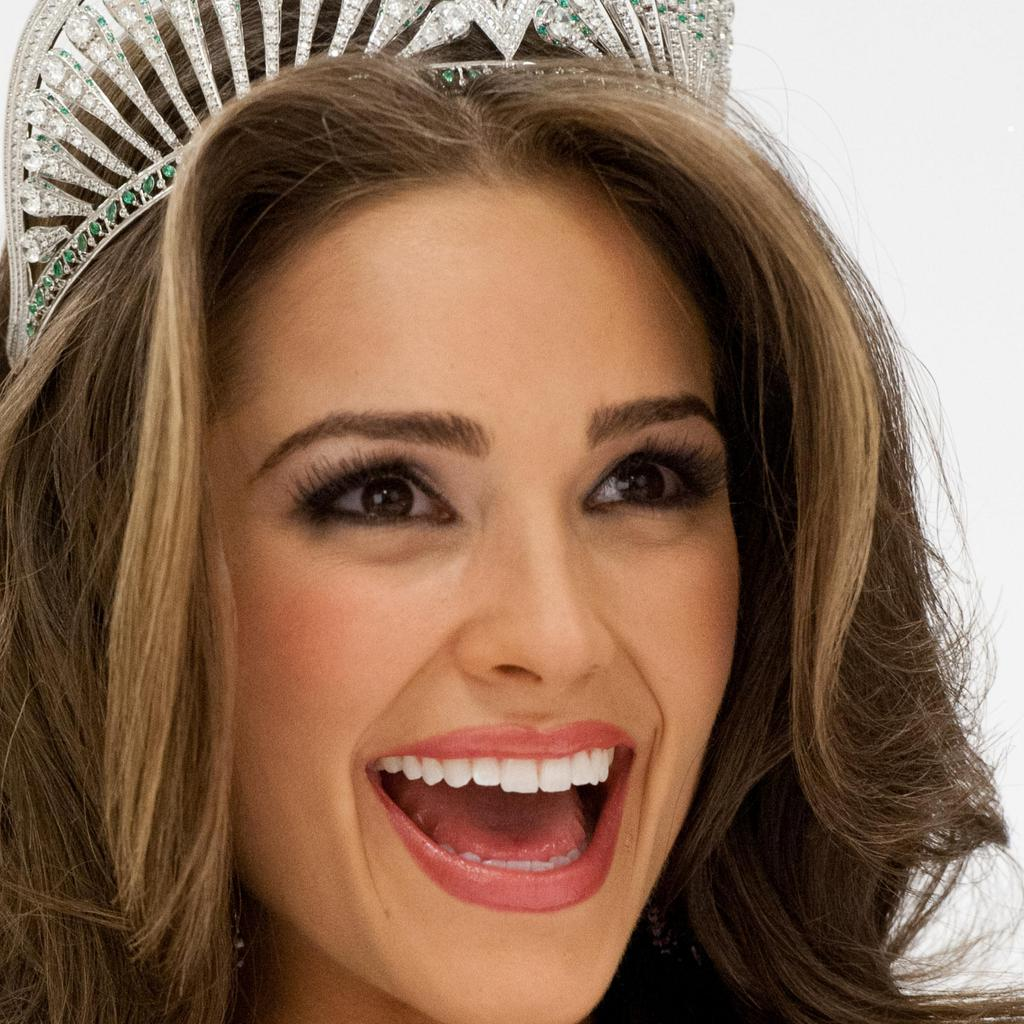

In [5]:
example = dataset["train"][0]
image = example["image"]
image

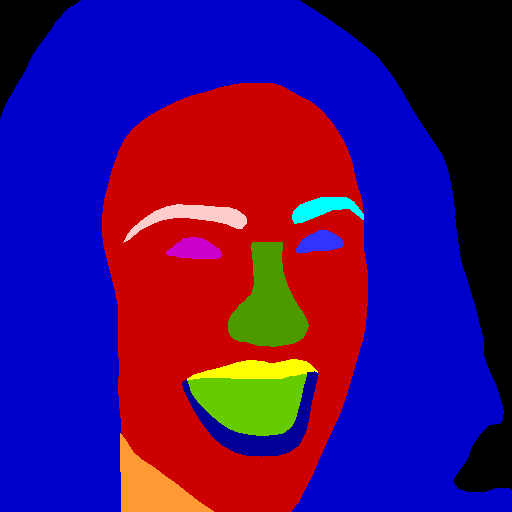

In [6]:
segmentation_map = example["label"]
segmentation_map

In case of semantic segmentation, every pixel is labeled with a certain class. 0 is the "background" class.

In [7]:
import numpy as np

segmentation_map = np.array(segmentation_map)
segmentation_map

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0, 204],
        [  0,   0, 204],
        [  0,   0, 204],
        ...,
        [  0,   0, 204],
        [  0,   0, 204],
        [  0,   0, 204]],

       [[  0,   0, 204],
        [  0,   0, 204],
        [  0,   0, 204],
        ...,
        [  0,   0, 204],
        [  0,   0, 204],
        [  0,   0, 204]],

       [[  0,   0, 204],
        [  0,   0, 204],
        [  0,   0, 204],
        ...,
        [  0,   0, 204],
        [  0,   0, 204],
        [  0,   0, 204]]

Let's load the mappings between integers and their classes (I got that from the [dataset card](https://huggingface.co/datasets/EduardoPacheco/FoodSeg103#data-categories) and asked an LLM to turn it into a dictionary).

We can visualize the segmentation map on top of the image, like so:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Your label and color lists
label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip',
              'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']

# Note: The color codes here are RGB
color_list = [(0, 0, 0), (204, 0, 0), (76, 153, 0), (204, 204, 0), (51, 51, 255), 
              (204, 0, 204), (0, 255, 255), (255, 204, 204), (102, 51, 0), (255, 0, 0), 
              (102, 204, 0), (255, 255, 0), (0, 0, 153), (0, 0, 204), (255, 51, 153), 
              (0, 204, 204), (0, 51, 0), (255, 153, 51)]

# Create id2label dictionary
id2label = {i: label for i, label in enumerate(label_list)}

# Create id2color dictionary
id2color = {i: color for i, color in enumerate(color_list)}

# Test print
print("id2label:", id2label)
print("id2color:", id2color)




id2label: {0: 'skin', 1: 'nose', 2: 'eye_g', 3: 'l_eye', 4: 'r_eye', 5: 'l_brow', 6: 'r_brow', 7: 'l_ear', 8: 'r_ear', 9: 'mouth', 10: 'u_lip', 11: 'l_lip', 12: 'hair', 13: 'hat', 14: 'ear_r', 15: 'neck_l', 16: 'neck', 17: 'cloth'}
id2color: {0: (0, 0, 0), 1: (204, 0, 0), 2: (76, 153, 0), 3: (204, 204, 0), 4: (51, 51, 255), 5: (204, 0, 204), 6: (0, 255, 255), 7: (255, 204, 204), 8: (102, 51, 0), 9: (255, 0, 0), 10: (102, 204, 0), 11: (255, 255, 0), 12: (0, 0, 153), 13: (0, 0, 204), 14: (255, 51, 153), 15: (0, 204, 204), 16: (0, 51, 0), 17: (255, 153, 51)}


(512, 512, 3)


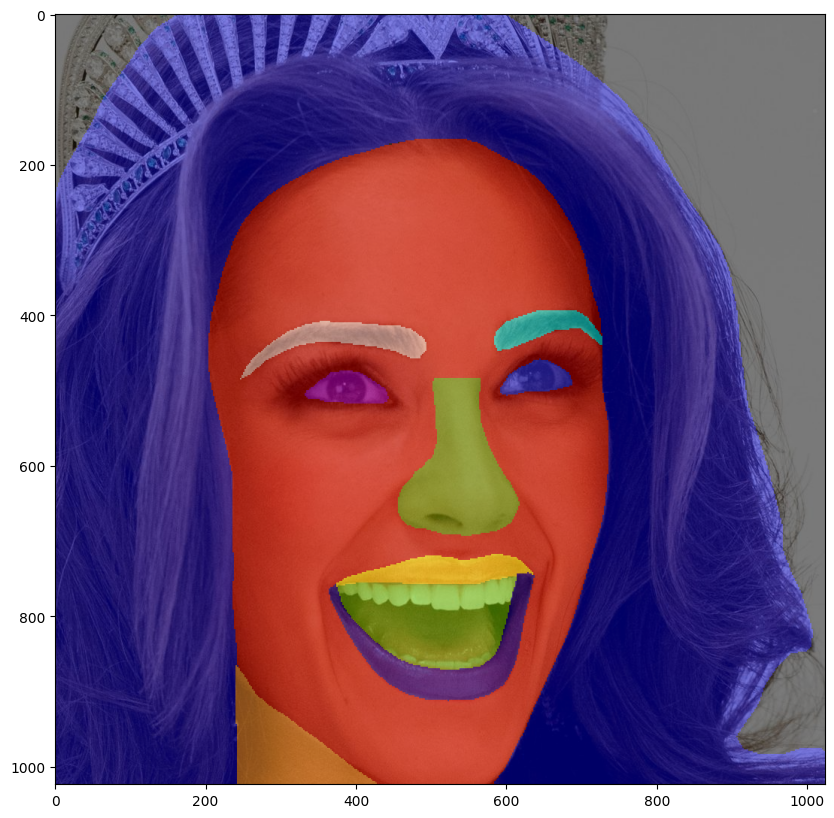

In [9]:
import cv2
print(segmentation_map.shape)
def color_to_label(segmentation_map_rgb, id2color):
    height, width, _ = segmentation_map_rgb.shape
    segmentation_map_label = np.zeros((height, width), dtype=np.uint8)

    for label, color in id2color.items():
        mask = np.all(segmentation_map_rgb == np.array(color).reshape(1, 1, 3), axis=2)
        segmentation_map_label[mask] = label

    return segmentation_map_label
segmentation_map_label = color_to_label(segmentation_map, id2color)
segmentation_map_label_resized = cv2.resize(segmentation_map_label, (1024, 1024), interpolation=cv2.INTER_NEAREST)

def visualize_map(image, segmentation_map):
    height, width = segmentation_map.shape
    color_seg = np.zeros((height, width, 3), dtype=np.uint8)  # Initialize a blank (height, width, 3) array
    
    for label, color in id2color.items():
        mask = (segmentation_map == label)  # This is a 2D mask
        for i in range(3):  # Loop for R,G,B channels
            # Apply mask to each channel individually
            color_seg[:,:,i][mask] = color[i]

    # Combine the original image and the colorized segmentation map
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()
visualize_map(image, segmentation_map_label_resized)



## Create PyTorch dataset

We create a regular PyTorch dataset, which prepares the examples for the model. We augment the training images by random resizing and cropping them to a fixed resolution (448x448), and normalize the color channels. This way, all our training images will have the same fixed resolution. Here we use the [Albumentations](https://albumentations.ai/) library for that purpose, but note that one can also use other libraries like Torchvision or Kornia.

 Note that the model will expect `pixel_values` of shape (batch_size, num_channels, height, width) as input. As Albumentations works on NumPy arrays (which uses a channels-last format), we make sure that the channels are first. The `labels` which the model also expects are of shape (batch_size, height, width) and indicate the ground truth label per pixel, for every example in the batch.

In [10]:
from torch.utils.data import Dataset
import torch
import cv2
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        original_image = np.array(item["image"])  # Make sure this is a NumPy array
        original_segmentation_map = np.array(item["label"])  # Make sure this is a NumPy array

        # Resize segmentation_map to have the same dimensions as the original image
        original_segmentation_map = color_to_label(original_segmentation_map, id2color)
        original_segmentation_map = cv2.resize(original_segmentation_map, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Apply transformations
        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, target = torch.tensor(transformed['image']), torch.tensor(transformed['mask'], dtype=torch.long)

        # Convert to C, H, W format
        image = image.permute(2, 0, 1)

        return image, target, original_image, original_segmentation_map


Let's create the training and validation datasets (note that we only randomly crop for training images).

In [11]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    # hadded an issue with an image being too small to crop, PadIfNeeded didn't help...
    # if anyone knows why this is happening I'm happy to read why
    # A.PadIfNeeded(min_height=448, min_width=448),
    # A.RandomResizedCrop(height=448, width=448),
    A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

val_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["validation"], transform=val_transform)

In [12]:
pixel_values, target, original_image, original_segmentation_map = train_dataset[3]
print(pixel_values.shape)
print(target.shape)

torch.Size([3, 448, 448])
torch.Size([448, 448])


In [13]:
print("Shape of segmentation_map_label:", segmentation_map_label.shape)
unique_values = np.unique(segmentation_map_label)
print("Unique values in segmentation_map_label:", unique_values)
try:
    unique_labels = [id2label[id] for id in unique_values]
    print("Corresponding labels:", unique_labels)
except KeyError as e:
    print(f"KeyError: {e} is not in id2label")


Shape of segmentation_map_label: (512, 512)
Unique values in segmentation_map_label: [ 0  1  2  4  5  6  7 10 11 12 13 17]
Corresponding labels: ['skin', 'nose', 'eye_g', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'u_lip', 'l_lip', 'hair', 'hat', 'cloth']


## Create PyTorch dataloaders

Next, we create PyTorch dataloaders, which allow us to get batches of data (as neural networks are trained on batches using stochastic gradient descent or SGD). We just stack the various images and labels along a new batch dimension.

In [14]:
from torch.utils.data import DataLoader

def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


Let's check a batch:

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([2, 3, 448, 448])
labels torch.Size([2, 448, 448])


Note that the pixel values are float32 tensors, whereas the labels are long tensors:

In [16]:
batch["pixel_values"].dtype

torch.float32

In [17]:
batch["labels"].dtype

torch.int64

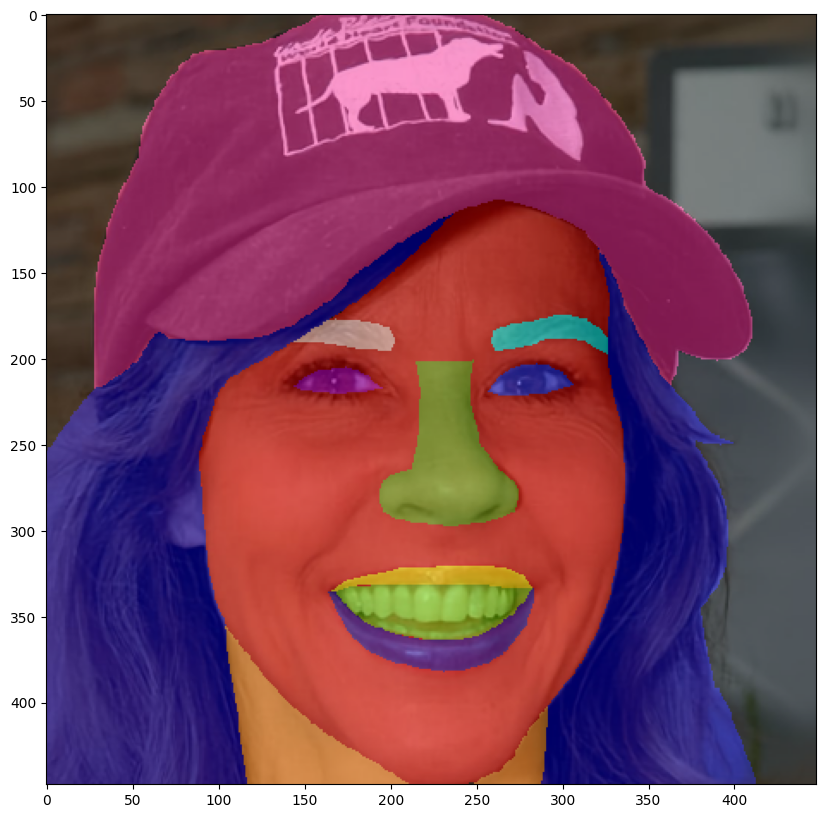

In [18]:
from PIL import Image

# Unnormalize the image
unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

# Move axes from C,H,W to H,W,C for visualization
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

# Convert to PIL image for better visualization
unnormalized_image = Image.fromarray(unnormalized_image)

# Your labels should already be single-channel, so you can use them directly
segmentation_map_label = batch["labels"][0].numpy()

# Visualize
visualize_map(unnormalized_image, segmentation_map_label)


## Define model

Next, we define the model, which consists of DINOv2 as backbone + a linear classifier on top. DINOv2 is a regular vision transformer, hence it outputs "patch embeddings", meaning an embedding vector for each image patch. Since we use an image resolution of 448 pixels, and we use a DINOv2 model that has a patch resolution of 14 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L19), we get (448/14)**2 = 1024 patches out. So the model outputs a tensor of shape (batch_size, number of patches, hidden_size) = (batch_size, 1024, 768) for a batch of images (the model has a hidden size - also called embedding dimension - of 768 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L9)).

Next, we reshape this tensor to become (batch_size, 32, 32, 768), after which we apply the linear layer (below implemented as a Conv2D layer - which is equivalent to a linear transformation when you employ a kernel size of 1x1). This conv2D layer converts the patch embeddings into a logits tensor of shape (batch_size, num_labels, height, width) - which is what we need for semantic segmentation. This tensor contains scores as predicted by the model for all of the classes, for each pixel, for every example in the batch.

In [19]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\q42\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [20]:
import transformers
import torch
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput

class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)


class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.dinov2 = Dinov2Model(config)
    self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)

  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                        output_hidden_states=output_hidden_states,
                        output_attentions=output_attentions)
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = outputs.last_hidden_state[:,1:,:]

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)
    logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)
    loss = None
    if labels is not None:
      # important: we're going to use 0 here as ignore index instead of the default -100
      # as we don't want the model to learn to predict background
      loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
      loss = loss_fct(logits.squeeze(), labels.squeeze())

    return SemanticSegmenterOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )


We can instantiate the model as follows:

In [21]:
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.weight', 'classifier.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Important: we don't want to train the DINOv2 backbone, only the linear classification head. Hence we don't want to track any gradients for the backbone parameters. This will greatly save us in terms of memory used:

In [22]:
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False

Let's perform a forward pass on a random batch, to verify the shape of the logits, verify we can calculate a loss:

In [23]:
outputs = model(pixel_values=batch["pixel_values"], labels=batch["labels"])


In [24]:
print(outputs.logits.shape)
print(outputs.loss)

torch.Size([2, 18, 448, 448])
tensor(3.2115, grad_fn=<NllLoss2DBackward0>)


As can be seen, the logits are of shape (batch_size, num_labels, height, width). We can then just take the highest logit (score) for each pixel as the model's prediction.

## Train the model

We'll train the model in regular PyTorch fashion. We also use the mIoU (mean Intersection-over-Union) metric to evaluate the performance during training.

Note that I made this entire notebook just for demo purposes, I haven't done any hyperparameter tuning, so feel free to improve. You can also of course use other training frameworks (like the 🤗 Trainer, PyTorch Lightning, 🤗 Accelerate, ...).

In [25]:
import evaluate

metric = evaluate.load("mean_iou")

In [33]:
from torch.optim import AdamW
from tqdm.auto import tqdm

# training hyperparameters
# NOTE: I've just put some random ones here, not optimized at all
# feel free to experiment, see also DINOv2 paper
learning_rate = 5e-5
epochs = 10

optimizer = AdamW(model.parameters(), lr=learning_rate)

# put model on GPU (set runtime to GPU in Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# put model in training mode
model.train()

for epoch in range(epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(tqdm(train_dataloader)):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      # evaluate
      with torch.no_grad():
        predicted = outputs.logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

      # let's print loss and metrics every 2 batches
      if idx % 2 == 0:
        metrics = metric.compute(num_labels=len(id2label),
                                ignore_index=0,
                                reduce_labels=False,
        )

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/13500 [00:00<?, ?it/s]

C:\Users\q42\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 3.0964066982269287
Mean_iou: 0.03147891540154732
Mean accuracy: 0.12335707295517935
Loss: 2.817080020904541
Mean_iou: 0.029563018687351967
Mean accuracy: 0.11026118376689505
Loss: 2.9355499744415283
Mean_iou: 0.023209326907533547
Mean accuracy: 0.12720046955906833
Loss: 3.041994571685791
Mean_iou: 0.031149474972973816
Mean accuracy: 0.10885006513386991
Loss: 2.811641216278076
Mean_iou: 0.0204969884587463
Mean accuracy: 0.09821191118790275
Loss: 2.933558940887451
Mean_iou: 0.02274337852561797
Mean accuracy: 0.11073809084953345
Loss: 2.862689733505249
Mean_iou: 0.030964778923629824
Mean accuracy: 0.11285327108558615
Loss: 2.725560188293457
Mean_iou: 0.026195942824456465
Mean accuracy: 0.10849487460721534
Loss: 2.525636672973633
Mean_iou: 0.03843289417813895
Mean accuracy: 0.12680051468765163
Loss: 2.3430051803588867
Mean_iou: 0.04372693622640952
Mean accuracy: 0.11721561398469264
Loss: 2.3465967178344727
Mean_iou: 0.05590299646612461
Mean accuracy: 0.19396439990672432
Loss: 2.58639

C:\Users\q42\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


Loss: 1.8559505939483643
Mean_iou: 0.10660784188136217
Mean accuracy: 0.23249155640629496
Loss: 1.8058449029922485
Mean_iou: 0.10455923480504477
Mean accuracy: 0.21839411282333618
Loss: 1.8184404373168945
Mean_iou: 0.10372205260001655
Mean accuracy: 0.21349119189543445
Loss: 1.6385793685913086
Mean_iou: 0.08882263873016094
Mean accuracy: 0.1669348073888587
Loss: 1.8575785160064697
Mean_iou: 0.09312143503892473
Mean accuracy: 0.21163632052856327
Loss: 1.2942767143249512
Mean_iou: 0.11436398167783876
Mean accuracy: 0.21589492617888334
Loss: 1.3998384475708008
Mean_iou: 0.11977033025034774
Mean accuracy: 0.21402690715925524
Loss: 1.6553897857666016
Mean_iou: 0.13247177684300393
Mean accuracy: 0.27280633115759945
Loss: 1.31221604347229
Mean_iou: 0.09815737636666753
Mean accuracy: 0.1537123741600577
Loss: 1.4682958126068115
Mean_iou: 0.12643967604620612
Mean accuracy: 0.23433698000689837
Loss: 1.2421456575393677
Mean_iou: 0.09247410358363711
Mean accuracy: 0.15328543365907452
Loss: 1.286261

KeyboardInterrupt: 

## Inference

Once we've trained a model, we can perform inference on new images as follows:

In [34]:
model.eval()  # Set the model to evaluation mode


Dinov2ForSemanticSegmentation(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
      

In [35]:
from albumentations.pytorch import ToTensorV2

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = val_transform(image=image)  # Assuming val_transform is your validation transformation
    return transformed['image']


In [41]:
# Your albumentations validation transformation (as you have defined it before)
val_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
    ToTensorV2()  # Convert image to PyTorch tensor
])

# Update preprocess_image to work with an image array instead of an image path
def preprocess_image(image_array):
    transformed = val_transform(image=image_array)  # Apply the same transformations as during validation
    return transformed['image']

with torch.no_grad():
    # Get an example image from the validation set
    example_image = np.array(dataset["validation"][2]["image"])  # Make sure to convert to NumPy array if it's not

    # Preprocess the image
    input_image = preprocess_image(example_image)

    # Add a batch dimension and send the image to the device
    input_image = input_image.unsqueeze(0).to(device)

    # Perform inference
    output = model(pixel_values=input_image)

    # Get the predicted segmentation map
    pred = torch.argmax(output.logits, dim=1)

# Now you can use `pred` with your visualization function


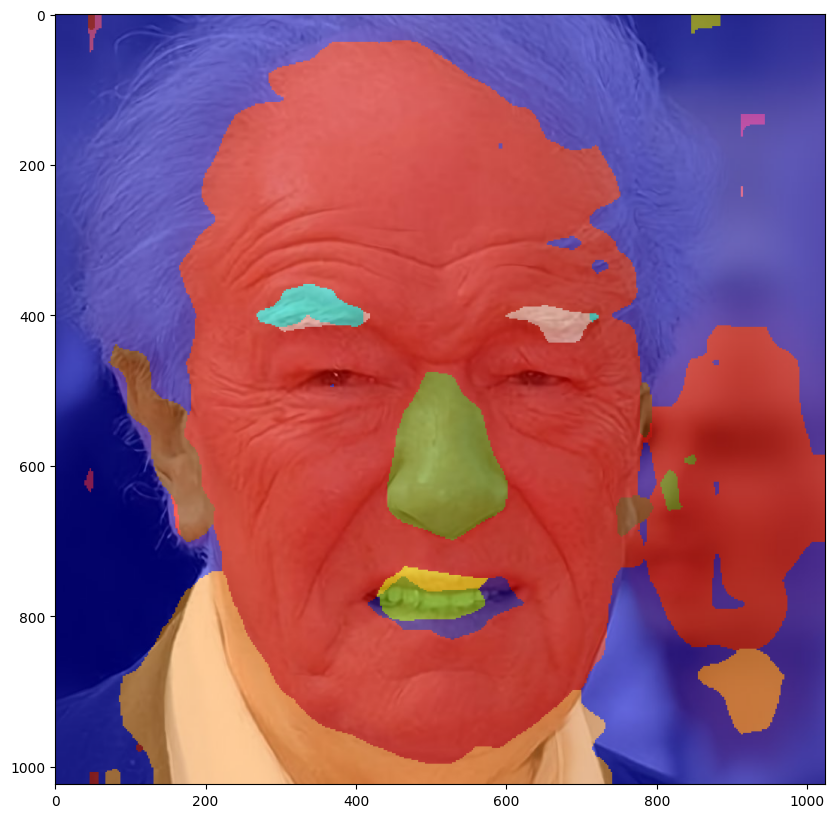

In [42]:
# Function to postprocess and visualize the segmentation
def postprocess_and_visualize(original_image, segmentation_output):
    # Convert PyTorch tensor to NumPy array and remove batch dimension
    segmentation_output = segmentation_output.cpu().numpy().squeeze()

    # Resize it to original image dimensions
    segmentation_output_resized = cv2.resize(segmentation_output, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
  
    # Visualize using your existing function
    visualize_map(original_image, segmentation_output_resized)

# Get an example image from the validation set
example_image = np.array(dataset["validation"][2]["image"])  # Make sure to convert to NumPy array if it's not

# Perform postprocessing and visualization
postprocess_and_visualize(example_image, pred)


In [ ]:
pixel_values = val_transform(image=np.array(test_image))["image"]
pixel_values = torch.tensor(pixel_values)
pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)

torch.Size([1, 3, 448, 448])


In [ ]:
upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=test_image.size[::-1],
                                                   mode="bilinear", align_corners=False)
predicted_map = upsampled_logits.argmax(dim=1)

This is just an illustrative example (I barely trained the model) but you can clearly see that training is working :) the model is able to segment the classes